# LLM Model Customization with Superwise:

### Fine-Tuning models with LLM-NEO and deploying them to **Superwise®**!

LLM-NEO is a LLM customization technique that combines distillation with LoRA in order to improve the efficiency of knowledge transfer and further compress an LLM beyond the capabilities of previous techniques, while maintaining model performance. LLM-NEO allows for knowladge transfer from a teacher LLM- which is not possible for LoRA adapters- and parameter-efficient tuning- which is not possible through distillation.

In this tutorial, I will demonstrate how to use LLAMA Factory with configurations from the LLM-NEO [paper](https://arxiv.org/pdf/2411.06839) in order to fine tune a LLM and deploy it to Superwise.

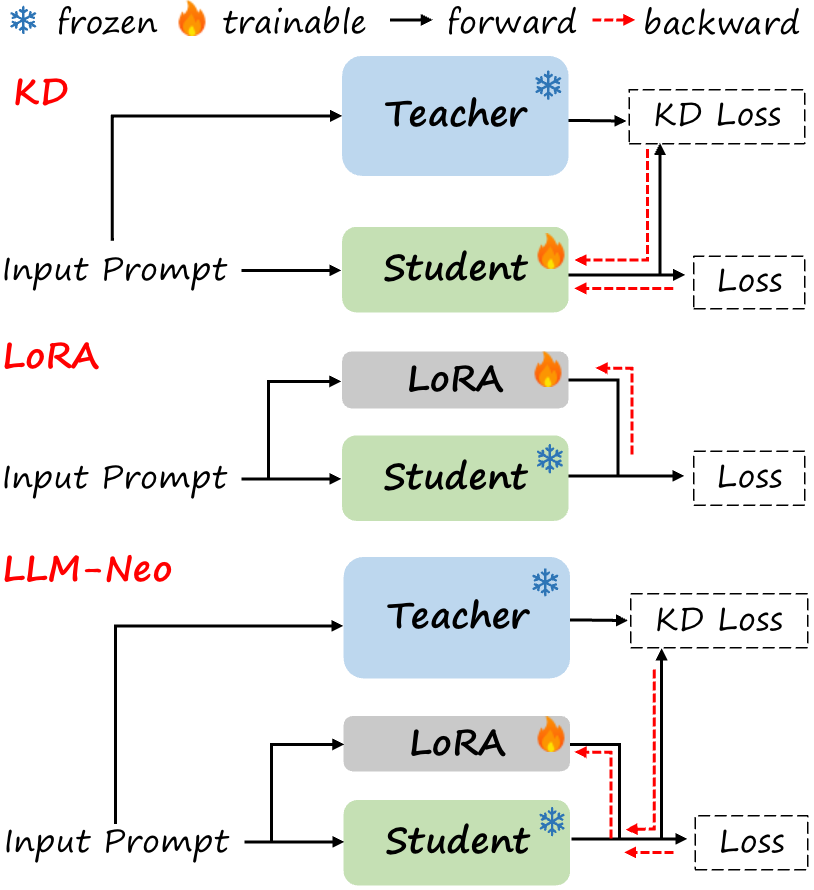

## **1. LLAMA Factory and LLM-NEO Installation**

In order to set up LLM-NEO, we first need to install LLAMA Factory, which is packaged with the LLM-NEO configuration scripts in [this](https://github.com/yang3121099/LLM-Neo) github repository.

Once the repository is downloaded, enter that directory and install the required packages.

In [ ]:
git clone --depth 1 https://github.com/yang3121099/LLM-Neo.git
cd LLM-Neo
pip install -e ".[torch,metrics]"

## **2. LLM-NEO Configuration Script**

For quick usage of LLAMA Factory, the script_Neo.py python script will generate a reccommended configuration file based on a few specified parameters. You can run the script without any arguments in order to generate the default configurations, or you can include any of the following parameters in order to customize your training job.
<br></br>

**model_family:** default='llama3', Base model family name

**model_size:** default='1b', Model size variant

**base_model:** default='Llama-3.2-1B', path to base model

**teacher_model_name_or_path:** default='DeepSeek-R1-Distill-Llama-8B', Teacher model path- can be empty

**base_lr:** default=2e-5, Base learning rate

**epochs:** default=1.0, Training epochs

**batch_size:** default=1, Batch size per device

**grad_accum:** default=8, Gradient accumulation steps

**cutoff_len:** default=2048, Context length

**template:** default='llama3', Prompt template

**max_samples:** default=10000, Max samples per dataset

**lora_rank:** default=64, LoRA rank size

**kd_ratio:** default=0.5, Knowledge distillation ratio

**logging_steps:** default=10, Interval between logging

**save_steps:** default=100, Save checkpoint interval

**plot_loss:** action='store_true', Enable loss plotting

**overwrite_cache:** action='store_true', Overwrite processed data

**output_root:** default='saves', Root output directory

**run:** nargs='*', choices=['sft', 'lora', 'kd', 'neo'], Configs to generate (default: all)'

<br></br>
Below are two examples for generating training configurations.

In [ ]:
python3 script_Neo.py --run lora neo --lora_rank 32 --base_model meta-llama/Meta-Llama-3-8B-Instruct

In [ ]:
python3 script_Neo.py --run kd neo --base_model meta-llama/Meta-Llama-3-8B-Instruct --teacher_model_name_or_path deepseek-ai/DeepSeek-R1-Distill-Llama-8B

The configuration I will be using is as follows

In [ ]:
# Model configuration and KD
model_name_or_path: ""
teacher_model_name_or_path: ""
kd_ratio: 0.5

# Training methodology
stage: sft
do_train: true
finetuning_type: lora
lora_rank: 64
lora_target: all
deepspeed: examples/deepspeed/ds_z2_config.json  # options: [ds_z0_config.json, ds_z2_config.json, ds_z3_config.json]

# Dataset configuration
dataset: BAAI-Infinity-Instruct-0625
template: llama3
cutoff_len: 2048
max_samples: 10000
overwrite_cache: false
preprocessing_num_workers: 16

# Output configuration
output_dir: saves/llama3-1b/lora/neo
logging_steps: 10
save_steps: 100
plot_loss: false
overwrite_output_dir: true

# Training parameters
per_device_train_batch_size: 1
gradient_accumulation_steps: 8
learning_rate: 2.0e-04
num_train_epochs: 1.0
lr_scheduler_type: cosine
warmup_ratio: 0.1
bf16: true
ddp_timeout: 180000000

In the above config file, you can see that I am using a parameter called "deepspeed". Deepspeed is a tool that allows for performance optimizations in training and inference. There are several default options for deepspeed. The configuration I am using is as follows.

In [ ]:
{
  "train_batch_size": "auto",
  "train_micro_batch_size_per_gpu": "auto",
  "gradient_accumulation_steps": "auto",
  "gradient_clipping": "auto",
  "zero_allow_untested_optimizer": true,
  "fp16": {
    "enabled": "auto",
    "loss_scale": 0,
    "loss_scale_window": 1000,
    "initial_scale_power": 16,
    "hysteresis": 2,
    "min_loss_scale": 1
  },
  "bf16": {
    "enabled": "auto"
  },
  "zero_optimization": {
    "stage": 2,
    "offload_optimizer": {
      "device": "cpu",
      "pin_memory": true
    },
    "allgather_partitions": true,
    "allgather_bucket_size": 5e8,
    "overlap_comm": true,
    "reduce_scatter": true,
    "reduce_bucket_size": 5e8,
    "contiguous_gradients": true,
    "round_robin_gradients": true
  }
}

## **3. Run LLM-NEO**

Now that we have all of the required training configs set up, it is time to begin training. Using LLama Factory, this step is easy. Simply run the run_train.sh script and sit back while LLAMA Factory handles the rest.

In [ ]:
bash run_train.sh

Depending on what model and training settings you used, the time it takes for this process to finish can vary greatly. Using the configuration I provided above and training on a machine with four T4 GPUs, this process took me about 3 hours.

Once this is complete, you can view the training graphs with tensorboard.

In [ ]:
from tensorboard import notebook
log_dir = "results/runs"
notebook.start("--logdir {} --port 4000".format(log_dir))

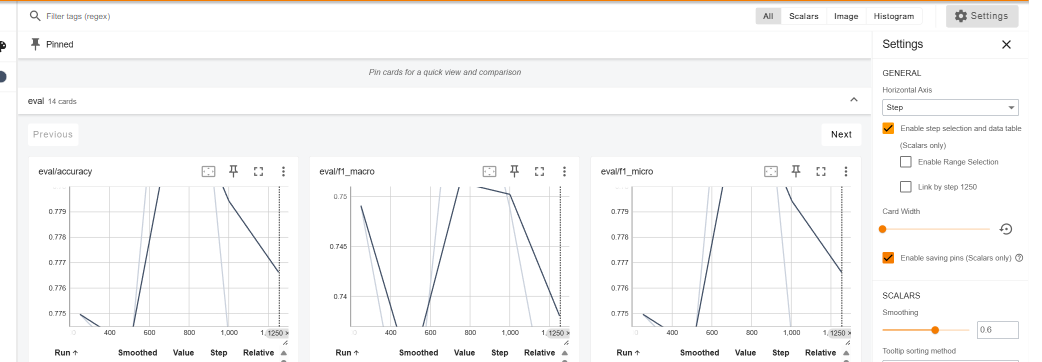

## **4. Deploy Model to Superwise App**

In order to use our new model within a Superwise application, it first needs to be deployed to a cloud endpoint. The Superwise platform is compatible with any provider that uses an OpenAI-compatible api endpoint, so check if the provider you are using conforms to this standard. I prefer to deploy my models using Google Cloud (GCP). The requirements for using a model deployed to a GCP endpoint within a Superwise application can be found [here](https://docs-swe.superwise.ai/docs/gcp-requirements).

Once the model endpoint is deployed through a cloud provider, the endpoint can be access through any Superwise application. A tutorial for how to set a Superwise application up can be found [here](https://docs-swe.superwise.ai/docs/build-a-new-gen-ai-app).

## **5. Superwise App Inference Through the API**

In order to inference the new model through the API, a Superwise Client connection with appropriate client id and client secret are required.

In [ ]:
client_id = ''
client_secret = ''

sw = SuperwiseClient(client_id = client_id, client_secret = client_secret)

After a connection is established with the Superwise Client, the application can be directly accessed using the following function.

In [ ]:
def ask_application_via_api(app_id, app_token, user_input):
  endpoint_url = f"https://api.superwise.ai/v1/app-worker/{app_id}/v1/ask"

  print(app_id)
  print(user_input)
  print(app_token)

  payload = {
    "chat_history": [],
    "input": user_input,
    #"prompt": prompt
  }

  headers = {
    "accept": "application/json",
    "content-type": "application/json",
    "x-api-token": app_token
}

  resp = requests.post(endpoint_url, json=payload, headers=headers)
  app_response = resp.json()
  return app_response

To use this function, the app id and app token are required.

In [ ]:
#get the app id and the app token
app_id = sw.application.get(name="LLM_NEO_Test_App").items[0].id
app_token = str(sw.application.get(name="LLM_NEO_Test_App").items[0].api_token)
print(app_id)
print(app_token)

Now that everything is set up, we are ready to make an inference!

In [ ]:
llm_neo_question = "How would the Future of AI in 10 Years look?"

llm_neo_answer = ask_application_via_api(app_id, app_token, llm_neo_question)
llm_neo_answer["output"]